#Import libraries


In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import nltk

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

import sklearn.metrics
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay,roc_auc_score,confusion_matrix
from sklearn.naive_bayes import MultinomialNB

#Loading the dataset

In [77]:
sms_data = files.upload()

Saving SMSspam.csv to SMSspam (1).csv


In [78]:
data = pd.read_csv("SMSspam.csv",encoding="utf-8")
data

,Class,input Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will √º b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [6]:
data.head()

,Class,input Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [80]:
# Target Encoding
data['spam'] = data['Class'].map( {'spam': 1, 'ham': 0} ).astype(int)

In [81]:
# Added length of each string
data['length'] = data['input Text'].apply(len)

In [82]:
# Renaming input column
data.rename(columns={'input Text': 'text'}, inplace=True)

In [83]:
# drop unnecessary column
data.drop('Class', axis=1, inplace=True)

In [84]:
data.head()

,text,spam,length
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives aro...",0,61


#Data Preprocessing

#1. Remove Punctuation and Stopwords

Punctuation can provide grammatical context to a sentence which supports our understanding. But for our vectorizer which counts the number of words and not the context, it does not add value, so we remove all special characters.

In [85]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Stopwords are common words that will likely appear in any text. They don’t tell us much about our data so we remove them.

In [86]:
from nltk.corpus import stopwords
stopwords.words("english")[10:15]

["you've", "you'll", "you'd", 'your', 'yours']

With the above lists for punctuation characters and stop words, we define a function to remove these from the text. This function will also convert all text to lowercase.

Tokenizing separates text into units such as sentences or words. It gives structure to previously unstructured text.

In [87]:
# Preprocessing steps
def remove_punctuation_and_stopwords(message):
    # remove punctuation
    message_without_punc = [ch for ch in message if ch not in string.punctuation]
    
    # tokenize
    message_without_punc = "".join(message_without_punc).split()
    
    # remove stopword
    message_without_punc_stopwords = \
        [word.lower() for word in message_without_punc if word.lower() not in stopwords.words("english")]
        
    return message_without_punc_stopwords

In [88]:
data['clean'] = data['text'].apply(remove_punctuation_and_stopwords)


In [89]:
data.head()

,text,spam,length,clean
0,"Go until jurong point, crazy.. Available only ...",0,111,"[go, jurong, point, crazy, available, bugis, n..."
1,Ok lar... Joking wif u oni...,0,29,"[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,U dun say so early hor... U c already then say...,0,49,"[u, dun, say, early, hor, u, c, already, say]"
4,"Nah I don't think he goes to usf, he lives aro...",0,61,"[nah, dont, think, goes, usf, lives, around, t..."


#2. Stemming

Stemming helps reduce a word to its stem form. It often makes sense to treat related words in the same way. It removes suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach. It reduces the corpus of words but often the actual words get neglected.

In [90]:
ps = nltk.PorterStemmer()

def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

In [91]:
data['stemmed'] = data['clean'].apply(stemming)
data.head()

,text,spam,length,clean,stemmed
0,"Go until jurong point, crazy.. Available only ...",0,111,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,Ok lar... Joking wif u oni...,0,29,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,U dun say so early hor... U c already then say...,0,49,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,"Nah I don't think he goes to usf, he lives aro...",0,61,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."


In [92]:
# Creating a dataframe for stemmed words
data_stem =  pd.DataFrame(data, columns = ['stemmed','spam'])

In [93]:
data_stem['stem'] = [' '.join(map(str, l)) for l in data['stemmed']]

In [94]:
# drop unnecessary column
data_stem.drop('stemmed', axis=1, inplace=True)

In [95]:
data_stem.head()

,spam,stem
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri 2 wkli comp win fa cup final tkt 21...
3,0,u dun say earli hor u c alreadi say
4,0,nah dont think goe usf live around though


#3. Lemmatization

Lemmatizing derives the canonical form (‘lemma’) of a word. i.e the root form. It is better than stemming as it uses a dictionary-based approach i.e a morphological analysis to the root word.

In [96]:
wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

In [98]:
data['lemmed'] = data['clean'].apply(lemmatizing)
data.head()

,text,spam,length,clean,stemmed,lemmed
0,"Go until jurong point, crazy.. Available only ...",0,111,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[go, jurong, point, crazy, available, bugis, n..."
1,Ok lar... Joking wif u oni...,0,29,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,U dun say so early hor... U c already then say...,0,49,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]","[u, dun, say, early, hor, u, c, already, say]"
4,"Nah I don't think he goes to usf, he lives aro...",0,61,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...","[nah, dont, think, go, usf, life, around, though]"


In [146]:
data_lem =  pd.DataFrame(data, columns = ['lem','spam'])
data_lem.head()

,lem,spam
0,NaN,0
1,NaN,0
2,NaN,1
3,NaN,0
4,NaN,0


In [99]:
# Creating a dataframe for stemmed words
data_lem =  pd.DataFrame(data, columns = ['lemmed','spam'])
# Converting it back to text
data_lem['lem'] = [' '.join(map(str, l)) for l in data['lemmed']]
# drop unnecessary column
data_lem.drop('lemmed', axis=1, inplace=True)

data_lem.head()

,spam,lem
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think go usf life around though


#Train Test Split using stemmed data

In [101]:
# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data_stem['stem'],
    data_stem['spam'],
    random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4180 4180
1394 1394


#Vectorization using Bag of Words
We already have the messages as lists of tokens (also known as lemmas), and we must now convert each of them into a vector that SciKit Learn's algorithm models can use.

We'll now convert each message, which is represented above as a list of tokens (lemmas), into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

Count how many times a word occurs in each message (term frequency)

Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Firstly,

Each vector will have the same number of dimensions as the number of distinct words in the SMS corpus. We'll start with the CountVectorizer from SciKit Learn. This model will transform a set of text documents into a token count matrix.

This can be shown as a two-dimensional matrix. Where the first dimension represents the full vocabulary (1 row per word) and the second dimension represents the actual documents, in this example a column per text message.

We should expect a lot of zero counts for the presence of that word in that document because there are so many messages. As a result, SciKit Learn will generate a Sparse Matrix.

In [102]:
# instantiate the vectorizer
vec = CountVectorizer()
vec.fit(X_train)

CountVectorizer()

In [104]:
# Create a document-term matrix from train and test sets
X_train_dtm = vec.transform(X_train)
X_test_dtm = vec.transform(X_test)

In [105]:
X_train_dtm

<4180x6917 sparse matrix of type '<class 'numpy.int64'>'
	with 35458 stored elements in Compressed Sparse Row format>

#Tuning Count Vectorizer
max_df: float in range [0.0, 1.0] or int, default=1.0

When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

min_df: float in range [0.0, 1.0] or int, default=1

When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

max_features: int, default=None If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.This parameter is ignored if vocabulary is not None.

#Manually selecting features

In [106]:
vec_tuned = CountVectorizer(stop_words='english',
                              ngram_range=(1,2),
                              min_df=0, 
                              max_df=0.8,
                              max_features=1000)

In [107]:
vec_tuned.fit(X_train)

CountVectorizer(max_df=0.8, max_features=1000, min_df=0, ngram_range=(1, 2),
                stop_words='english')

In [108]:
# Create a document-term matrix from train and test sets
X_train_dtm_tuned = vec_tuned.transform(X_train)
X_test_dtm_tuned = vec_tuned.transform(X_test)

#Using GridSearchCV to select best parameters

In [109]:
pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', MultinomialNB()),
])
parameters = [{
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1,3),), 
    'clf__alpha': (0.00001, 0.000001),
},{
    'vect': ([CountVectorizer()]),
    'clf__alpha': (0.00001, 0.000001),

}]

In [110]:
grid_search = GridSearchCV(pipeline, parameters)


In [111]:
grid_search.estimator.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'vect', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__norm', 'vect__preprocessor', 'vect__smooth_idf', 'vect__stop_words', 'vect__strip_accents', 'vect__sublinear_tf', 'vect__token_pattern', 'vect__tokenizer', 'vect__use_idf', 'vect__vocabulary', 'clf__alpha', 'clf__class_prior', 'clf__fit_prior'])

In [112]:
grid_search.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid=[{'clf__alpha': (1e-05, 1e-06),
                          'vect__max_df': (0.5, 0.75, 1.0),
                          'vect__max_features': (None, 5000, 10000, 50000),
                          'vect__ngram_range': ((1, 1), (1, 2), (1, 3))},
                         {'clf__alpha': (1e-05, 1e-06),
                          'vect': [CountVectorizer()]}])

In [113]:
print(grid_search.best_params_)

{'clf__alpha': 1e-05, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__ngram_range': (1, 2)}


#Training a Multinomial Naive Bayes model on vectorized data
#Why Multinomial Naive Bayes ?
The Multinomial Naive Bayes algorithm is a Bayesian learning approach popular in Natural Language Processing (NLP). The program guesses the tag of a text, such as an email or a newspaper story, using the Bayes theorem. It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance.

In our case, we have a frequency as a feature. In such a scenario, we use multinomial Naive Bayes. It ignores the non-occurrence of the features. So, if you have frequency 0 then the probability of occurrence of that feature will be 0 hence multinomial naive Bayes ignores that feature.

In [114]:
# Create a Multinomial Naive Bayes model
nb = MultinomialNB()

# Train the model
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [115]:
# Make class and probability predictions
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

Accuracy score : 0.98
Recall score : 0.96
Precision score : 0.94
F1 score : 0.93
ROC_AUC Score : 0.98


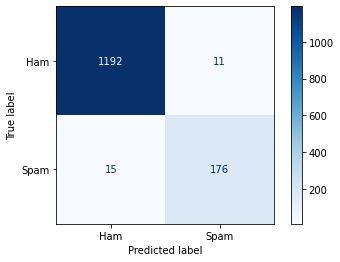

In [116]:
# calculate accuracy of class predictions
print("Accuracy score : {:.2f}".format(accuracy_score(y_test,y_pred_class)))

# calculate recall of class predictions
print("Recall score : {:.2f}".format(recall_score(y_test,y_pred_class,average='macro',zero_division=True)))

# calculate precision of class predictions
print("Precision score : {:.2f}".format(precision_score(y_test,y_pred_class,zero_division = True)))

# calculate f1 score of class predictions
print("F1 score : {:.2f}".format(f1_score(y_test,y_pred_class,zero_division=True)))

# calculate ROC_AUC score of class predictions
print("ROC_AUC Score : {:.2f}".format(roc_auc_score(y_test,y_pred_prob)))

# Create confusion matrix
dtcm = metrics.confusion_matrix(y_test, y_pred_class)
dis = ConfusionMatrixDisplay(dtcm,display_labels=["Ham","Spam"])
dis.plot(cmap=plt.cm.Blues)
plt.show()

#Training a Multinomial Naive Bayes model on manualy tuned vectorized data

In [117]:
nb_t = MultinomialNB()

# Train the model
nb_t.fit(X_train_dtm_tuned, y_train)

MultinomialNB()

In [118]:
# Make class and probability predictions
y_pred_class = nb_t.predict(X_test_dtm_tuned)
y_pred_prob = nb_t.predict_proba(X_test_dtm_tuned)[:, 1]

Accuracy score : 0.98
Recall score : 0.95
Precision score : 0.91
F1 score : 0.91
ROC_AUC Score : 0.98


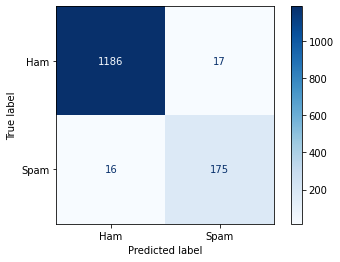

In [119]:
# calculate accuracy of class predictions
print("Accuracy score : {:.2f}".format(accuracy_score(y_test,y_pred_class)))

# calculate recall of class predictions
print("Recall score : {:.2f}".format(recall_score(y_test,y_pred_class,average='macro',zero_division=True)))

# calculate precision of class predictions
print("Precision score : {:.2f}".format(precision_score(y_test,y_pred_class,zero_division = True)))

# calculate f1 score of class predictions
print("F1 score : {:.2f}".format(f1_score(y_test,y_pred_class,zero_division=True)))

# calculate ROC_AUC score of class predictions
print("ROC_AUC Score : {:.2f}".format(roc_auc_score(y_test,y_pred_prob)))

# Create confusion matrix
dtcm = metrics.confusion_matrix(y_test, y_pred_class)
dis = ConfusionMatrixDisplay(dtcm,display_labels=["Ham","Spam"])
dis.plot(cmap=plt.cm.Blues)
plt.show()

#Training a Multinomial Naive Bayes model on Grid Search tuned vectorized data

In [120]:
# Make class and probability predictions
y_pred_class = grid_search.predict(X_test)
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]

Accuracy score : 0.98
Recall score : 0.95
Precision score : 0.96
F1 score : 0.93
ROC_AUC Score : 0.98


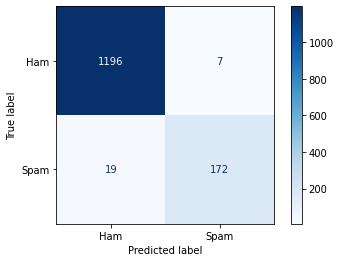

In [121]:
# calculate accuracy of class predictions
print("Accuracy score : {:.2f}".format(accuracy_score(y_test,y_pred_class)))

# calculate recall of class predictions
print("Recall score : {:.2f}".format(recall_score(y_test,y_pred_class,average='macro',zero_division=True)))

# calculate precision of class predictions
print("Precision score : {:.2f}".format(precision_score(y_test,y_pred_class,zero_division = True)))

# calculate f1 score of class predictions
print("F1 score : {:.2f}".format(f1_score(y_test,y_pred_class,zero_division=True)))

# calculate ROC_AUC score of class predictions
print("ROC_AUC Score : {:.2f}".format(roc_auc_score(y_test,y_pred_prob)))

# Create confusion matrix
dtcm = metrics.confusion_matrix(y_test, y_pred_class)
dis = ConfusionMatrixDisplay(dtcm,display_labels=["Ham","Spam"])
dis.plot(cmap=plt.cm.Blues)
plt.show()

Observation:
When GridSearchCV was used, the precision score improved to 0.96.